In [1]:
# Hide warnings on Jupyter Notebook
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import gc
import glob
import numpy as np
import platform

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

from keras.models import load_model
# from tensorflow.keras.models import load_model

from vis.visualization import visualize_saliency
from vis.visualization import visualize_cam
from vis.utils import utils
from keras import activations

from sklearn.externals import joblib

import subprocess
import shutil
from PIL import Image
import time

from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

Using TensorFlow backend.
/home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
img_size = 224
extra = 'big'
# img_size = 180
# img_size = 512
# model = load_model('model_0.h5')
if (platform.system() == "Windows"):
    model = load_model(os.path.join(os.getcwd(), '..', 'model.h5'))
else:
    # model = load_model(os.path.join(os.getcwd(), 'model.h5'))
    model = load_model(os.path.join(os.getcwd(), '..', 'model_{}_{}.h5'.format(img_size, extra)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [3]:
# print([layer.name for layer in model.get_layer('vgg16').layers])
# for layer in model.layers:
#     print(layer.name)
all_layer_names = [layer.name for layer in model.layers]
print(all_layer_names)

['conv2d_1', 'conv2d_2', 'max_pooling2d_1', 'conv2d_3', 'conv2d_4', 'max_pooling2d_2', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'max_pooling2d_3', 'conv2d_8', 'conv2d_9', 'conv2d_10', 'max_pooling2d_4', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'max_pooling2d_5', 'flatten_1', 'dense_1', 'dense_2', 'dense_3']


In [4]:
print(all_layer_names[-1])
print(utils.find_layer_idx(model, all_layer_names[-1]))

dense_3
21


In [5]:
if (platform.system() == "Windows"):
    render_folder = os.path.join(os.getcwd(), "..","greebles_10") #reduced dataset of 10
else:
    # render_folder = os.path.join(os.getcwd(),"greebles_10") #reduced dataset of 10
    render_folder = os.path.join(os.getcwd(), "..", "greebles_10") 

set_mode = 'specific_all'
set_type = 'specific_angle'
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)

# test_set_name = "greebles10_fgsm03_-90_90_1_224.npy".format(img_size)
test_set_name = "greebles10_test_-90_90_1_224.npy".format(img_size)
# test_set_name = "greebles10_upsidedown_-90_90_1_{}.npy".format(img_size)

labels = {0: 'f-1', 1: 'f-2', 2: 'f-3', 3: 'f-4', 4: 'f-5', 5: 'm-1', 6: 'm-2', 7: 'm-3', 8: 'm-4', 9: 'm-5'}
test_set_path = os.path.join(source_folder, test_set_name)
# all_test = np.load(test_set_path, allow_pickle=True).item()
all_test = joblib.load(test_set_path)

(10, 224, 224, 1)


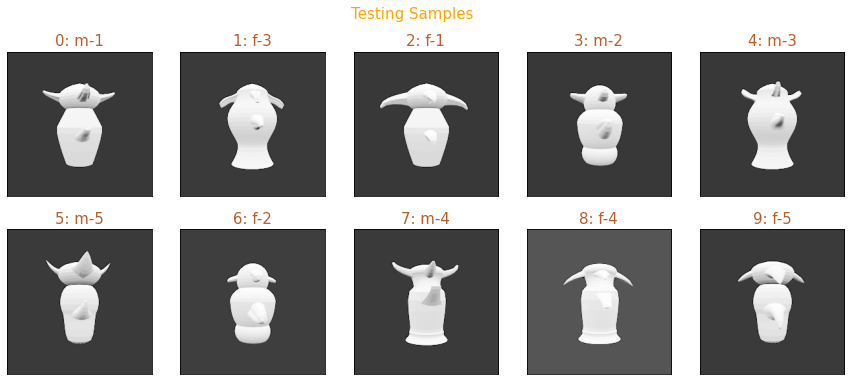

In [6]:
# Display one specific angle just as an example of what images are we using
angle_used = '10'
(x_test, y_test) = np.copy(all_test[angle_used][0]), np.copy(all_test[angle_used][1])
# Make background the same color
# x_test[x_test < 70] = 0
# x_test *= (1.0/255)
print(x_test.shape)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0], cmap='Greys_r')
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=labels[int(true_label)], number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

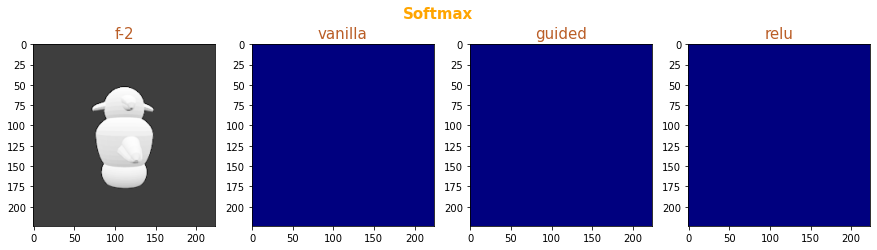

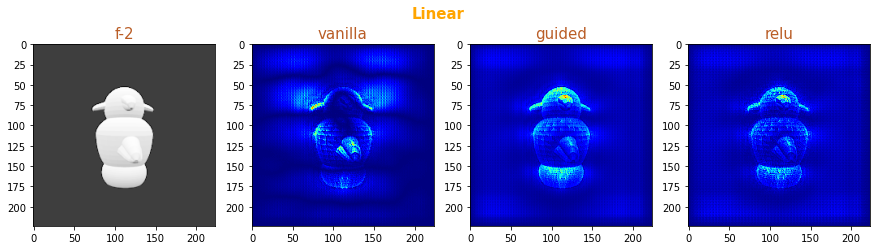

In [7]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 'dense_2')
layer_idx = utils.find_layer_idx(model, all_layer_names[-1])

# Example saliency visualization
class_idx = 1
indices = np.where(y_test[:, class_idx] == 1.)[0]
idx = indices[0] # pick some random input from here.

# Remove eventually to speed up
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

fig, ax = plt.subplots(1, 4, figsize=(15,6))
ax[0].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
ax[0].imshow(x_test[idx][..., 0], cmap='Greys_r')

for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    if modifier == None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier, color='#ba5e27', fontsize=15)
    ax[i+1].imshow(grads, cmap='jet')
fig.suptitle('Softmax', fontsize=15, color='orange', fontweight ="bold", y=0.8)
#############################################
# Swap softmax with linear for better results
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

fig, ax = plt.subplots(1, 4, figsize=(15,6))
ax[0].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
ax[0].imshow(x_test[idx][..., 0], cmap='Greys_r')

for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    if modifier == None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier, color='#ba5e27', fontsize=15)
    ax[i+1].imshow(grads, cmap='jet')
fig.suptitle('Linear', fontsize=15, color='orange', fontweight ="bold", y=0.8)

plt.show()

In [8]:
# # Remove eventually to speed up
# model.layers[layer_idx].activation = activations.softmax
# model = utils.apply_modifications(model)
# fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
# ax = ax.ravel()
# for class_idx in range(10):    
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     offset = class_idx*4
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0])
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate([None, 'guided', 'relu']):
#         grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
#                                    seed_input=x_test[idx], backprop_modifier=modifier)
#         if modifier is None:
#             modifier = 'vanilla'
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

# model.layers[layer_idx].activation = activations.linear
# model = utils.apply_modifications(model)

In [9]:
# # This corresponds to the Dense linear layer.
# model.layers[layer_idx].activation = activations.linear
# model = utils.apply_modifications(model)
# fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
# ax = ax.ravel()
# for class_idx in range(10):    
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     offset = class_idx*4
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0])
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate([None, 'guided', 'relu']):
#         grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
#                                    seed_input=x_test[idx], backprop_modifier=modifier)
#         if modifier is None:
#             modifier = 'vanilla'
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# # test_set_name
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

In [10]:
# # # Swap softmax with linear
# # model.layers[layer_idx].activation = activations.linear
# # model = utils.apply_modifications(model)

# # grad-CAM
# # layer_idx = utils.find_layer_idx(model, 'dense_2')
# layer_idx = utils.find_layer_idx(model, all_layer_names[-1])
# # layer_idx = utils.find_layer_idx(model, 'conv2d_2')

# penultimate_layer = utils.find_layer_idx(model, 'conv2d_2')
# # penultimate_layer = utils.find_layer_idx(model, 'max_pooling2d_5')

# fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
# ax = ax.ravel()
# for class_idx in range(10):    
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     offset = class_idx*4
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0], cmap='Greys_r')
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate([None, 'guided', 'relu']):
#         grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
#                                      seed_input=x_test[idx], backprop_modifier=modifier,
#                                      penultimate_layer_idx=penultimate_layer)
#         if modifier is None:
#             modifier = 'vanilla'
#             grads_vanilla = grads
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
        
#         ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
#         # ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='Greys_r', alpha=0.29)
        
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

In [11]:
# grads_vanilla

In [12]:
# # grad-CAM
# layer_idx = utils.find_layer_idx(model, 'dense_2')
# # layer_idx = utils.find_layer_idx(model, 'conv2d_2')

# # penultimate_layer = utils.find_layer_idx(model, 'conv2d_1')
# # penultimate_layer = utils.find_layer_idx(model, 'conv2d_12')
# penultimate_layer = utils.find_layer_idx(model, 'max_pooling2d_5')

# fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
# ax = ax.ravel()
# for class_idx in range(10):    
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     offset = class_idx*4
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0])
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate([None, 'guided', 'relu']):
#         grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
#                                      seed_input=x_test[idx], backprop_modifier=modifier,
#                                      penultimate_layer_idx=penultimate_layer)
#         if modifier is None:
#             modifier = 'vanilla'
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
        
#         ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
        
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

In [13]:
# # grad-CAM
# # layer_idx = utils.find_layer_idx(model, 'dense_2')
# layer_idx = utils.find_layer_idx(model, all_layer_names[-1])
# pen_layer_name = 'conv2d_13'
# # pen_layer_name = 'max_pooling2d_5'
# # penultimate_layer = utils.find_layer_idx(model, 'conv2d_2')
# # penultimate_layer = utils.find_layer_idx(model, 'conv2d_13')
# penultimate_layer = utils.find_layer_idx(model, pen_layer_name)

# print(labels)
# fig, ax = plt.subplots(2, 2, figsize=(15,4*2))
# ax = ax.ravel()
# counter = 0
# for class_idx in range(1,3):
#     print(class_idx)
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     # offset = class_idx*2
#     offset = counter*2
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0], cmap='Greys_r')
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate(['guided']):
#         grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
#                                      seed_input=x_test[idx], backprop_modifier=modifier,
#                                      penultimate_layer_idx=penultimate_layer)
#         if modifier is None:
#             modifier = 'vanilla'
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
        
#         ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
#         # ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='Greys_r', alpha=0.29)
        
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)

#         counter += 1
    
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

In [14]:
# Change these as needed
class_idx = 1
indices = np.where(y_test[:, class_idx] == 1.)[0]
idx = indices[0]

method_vis = ['saliency', 'gradcam']
# method_vis = [s + "_fgsm" for s in method_vis]

#### SELECT HERE #####
method_vis_select = method_vis[0]
view_pred_class = [0, 1, 2][2]
######################

vis_folder = "colormaps_sep/{}{}_{}_{}_{}".format(method_vis_select, view_pred_class, img_size, extra, test_set_name.split('_')[1])
last_layer_name = all_layer_names[-1]
pen_layer_name = 'conv2d_13'

penultimate_layer = utils.find_layer_idx(model, pen_layer_name)
layer_idx = utils.find_layer_idx(model, last_layer_name)

In [15]:
# # We have to do everything inside this loop, create video, etc
# # sal_dir = 'saliency_{}'.format(img_size)
# sal_dir = vis_folder
# print(sal_dir)
# os.makedirs(sal_dir, exist_ok=True)
# for c, current_angle in enumerate(all_test.keys()):
#     if os.path.exists("{}/{}_sal_{}.png".format(sal_dir, str(c).zfill(3), current_angle)):
#         print("Skipped {}".format(current_angle))
#         continue
    
#     if (int(current_angle)%10) != 0: pass
#     else:
#         print(current_angle, end=", ")     
#         (x_test, y_test) = np.copy(all_test[current_angle][0]), np.copy(all_test[current_angle][1])
        
#         # Because fgsm set is already divided by 255 and normalized
#         if "fgsm" not in test_set_name.split('_')[1]:
#             print("Normalizing...")
#             x_test *= (1.0/255)
        
#         y_pred = model.predict_classes(x_test)
        
#         # Make background the same color
# #         x_test[x_test < 70] = 0
        
#         fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
#         ax = ax.ravel()
#         for class_idx in range(10):
#             indices = np.where(y_test[:, class_idx] == 1.)[0]
#             idx = indices[0]

#             offset = class_idx*4
#             # ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#             ax[offset].set_title(f"{labels[class_idx]} -> {labels[y_pred[idx]]}", fontsize=15, color='#ba5e27')
#             im = ax[offset].imshow(x_test[idx][..., 0], cmap='gray', vmin=0, vmax=1, interpolation='none')
#             ax[offset].set_yticklabels([])
#             ax[offset].set_xticklabels([])
#             ax[offset].tick_params(axis=u'both', which=u'both', length=0)
#             divider = make_axes_locatable(ax[offset])
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             cbar = fig.colorbar(im, cax=cax, orientation='vertical')

#             if method_vis[0] == method_vis_select:
#                 modifier = None
#                 if view_pred_class == 1:
#                     grads = visualize_saliency(model, layer_idx, filter_indices=y_pred[idx], 
#                                         seed_input=x_test[idx], backprop_modifier=modifier)
#                 else:
#                     grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
#                                         seed_input=x_test[idx], backprop_modifier=modifier)
#                 if modifier is None:
#                     modifier = 'vanilla'
#                     for i, cmap in enumerate(['jet', 'gray', 'cividis',]):
#                         ax[offset+i+1].set_title(cmap, color='#ba5e27', fontsize=15)
#                         im = ax[offset+i+1].imshow(grads, cmap=cmap, vmin=0, vmax=1)
#                         ax[offset+i+1].set_yticklabels([])
#                         ax[offset+i+1].set_xticklabels([])
#                         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
#                         divider = make_axes_locatable(ax[offset+i+1])
#                         cax = divider.append_axes("right", size="5%", pad=0.05)
#                         cbar = fig.colorbar(im, cax=cax, orientation='vertical')
#                 pen_layer_name = 'input'
#             elif method_vis[1] == method_vis_select:
#                 modifier = None
#                 if view_pred_class == 1:
#                     grads = visualize_cam(model, layer_idx, filter_indices=y_pred[idx],
#                                             seed_input=x_test[idx], backprop_modifier=modifier,
#                                             penultimate_layer_idx=penultimate_layer)
#                 else:
#                     grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
#                                             seed_input=x_test[idx], backprop_modifier=modifier,
#                                             penultimate_layer_idx=penultimate_layer)
#                 if modifier is None:
#                     modifier = 'vanilla'
#                     for i, cmap in enumerate(['jet', 'gray', 'cividis',]):
#                         ax[offset+i+1].set_title(cmap, color='#ba5e27', fontsize=15)
#                         im = ax[offset+i+1].imshow(grads, cmap=cmap, vmin=0, vmax=1)

#                         ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.10)

#                         ax[offset+i+1].set_yticklabels([])
#                         ax[offset+i+1].set_xticklabels([])
#                         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
#                         divider = make_axes_locatable(ax[offset+i+1])
#                         cax = divider.append_axes("right", size="5%", pad=0.05)
#                         cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        
#         fig.tight_layout(rect=[0, 0, 1, 0.97])
#         st = fig.suptitle("{}°; {}; {}; PC:{}".format(current_angle, last_layer_name, pen_layer_name, view_pred_class), fontsize=20)
        
#         # cbar = fig.colorbar(im, ax=ax.tolist(), orientation='vertical', aspect=50)
#         # cbar.ax.tick_params(labelsize=15)
        
#         # fig.subplots_adjust(top=0.95)
#         plt.savefig("{}/{}_sal_{}.png".format(sal_dir, str(c).zfill(3), current_angle), bbox_extra_artists=[st], dpi=150, bbox_inches = "tight")
        
#         # Clear memory
# #         plt.show()
#         fig.clf()
#         fig.clear()
#         plt.close(fig)
#         gc.collect()
#         # break

# print("Done\n")
# print(x_test.shape)
# print(y_test.shape)

In [16]:
# We have to do everything inside this loop, create video, etc
sal_dir = vis_folder
print(sal_dir)
os.makedirs(sal_dir, exist_ok=True)
for c, current_angle in enumerate(all_test.keys()):
    if os.path.exists("{}/{}_sal_{}.png".format(sal_dir, str(c).zfill(3), current_angle)):
        print("Skipped {}".format(current_angle))
        continue
    
    if (int(current_angle)%10) != 0: pass
    else:
        print(current_angle, end=", ")
        (x_test, y_test) = np.copy(all_test[current_angle][0]), np.copy(all_test[current_angle][1])
        
        # Because fgsm set is already divided by 255 and normalized
        if "fgsm" not in test_set_name.split('_')[1]:
            print("Normalizing...")
            x_test *= (1.0/255)
        
        y_pred = model.predict_classes(x_test)

        if c == 0: 
            first_pred = [-1] * 10
        
        fig, ax = plt.subplots(1, 4, figsize=(15,4*1))
        ax = ax.ravel()
        for class_idx in range(10):
            indices = np.where(y_test[:, class_idx] == 1.)[0]
            idx = indices[0]

            if c == 0:
                first_pred[class_idx] = y_pred[idx]

            offset = 0
            ax[offset].set_title(f"{labels[class_idx]} -> {labels[y_pred[idx]]}", fontsize=15, color='#ba5e27')
            im = ax[offset].imshow(x_test[idx][..., 0], cmap='gray', vmin=0, vmax=1, interpolation='none')
            ax[offset].set_yticklabels([])
            ax[offset].set_xticklabels([])
            ax[offset].tick_params(axis=u'both', which=u'both', length=0)
            divider = make_axes_locatable(ax[offset])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = fig.colorbar(im, cax=cax, orientation='vertical')

            if method_vis[0] == method_vis_select:
                modifier = None
                if view_pred_class == 1:
                    grads = visualize_saliency(model, layer_idx, filter_indices=y_pred[idx], 
                                        seed_input=x_test[idx], backprop_modifier=modifier)
                elif view_pred_class == 2:
                    grads = visualize_saliency(model, layer_idx, filter_indices=first_pred[class_idx], 
                                        seed_input=x_test[idx], backprop_modifier=modifier)
                else:
                    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                        seed_input=x_test[idx], backprop_modifier=modifier)
                if modifier is None:
                    modifier = 'vanilla'
                    for i, cmap in enumerate(['jet', 'gray', 'cividis',]):
                        ax[offset+i+1].set_title(cmap, color='#ba5e27', fontsize=15)
                        im = ax[offset+i+1].imshow(grads, cmap=cmap, vmin=0, vmax=1)
                        ax[offset+i+1].set_yticklabels([])
                        ax[offset+i+1].set_xticklabels([])
                        ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
                        divider = make_axes_locatable(ax[offset+i+1])
                        cax = divider.append_axes("right", size="5%", pad=0.05)
                        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
                pen_layer_name = 'input'
            elif method_vis[1] == method_vis_select:
                modifier = None
                if view_pred_class == 1:
                    grads = visualize_cam(model, layer_idx, filter_indices=y_pred[idx],
                                            seed_input=x_test[idx], backprop_modifier=modifier,
                                            penultimate_layer_idx=penultimate_layer)
                elif view_pred_class == 2:
                    grads = visualize_cam(model, layer_idx, filter_indices=first_pred[class_idx],
                                            seed_input=x_test[idx], backprop_modifier=modifier,
                                            penultimate_layer_idx=penultimate_layer)
                else:
                    grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                                            seed_input=x_test[idx], backprop_modifier=modifier,
                                            penultimate_layer_idx=penultimate_layer)
                if modifier is None:
                    modifier = 'vanilla'
                    for i, cmap in enumerate(['jet', 'gray', 'cividis',]):
                        ax[offset+i+1].set_title(cmap, color='#ba5e27', fontsize=15)
                        im = ax[offset+i+1].imshow(grads, cmap=cmap, vmin=0, vmax=1)

                        ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.10)

                        ax[offset+i+1].set_yticklabels([])
                        ax[offset+i+1].set_xticklabels([])
                        ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
                        divider = make_axes_locatable(ax[offset+i+1])
                        cax = divider.append_axes("right", size="5%", pad=0.05)
                        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        
            fig.tight_layout(rect=[0, 0, 1, 0.97])
            st = fig.suptitle("{}°; {}; {}; PC:{}".format(current_angle, last_layer_name, pen_layer_name, view_pred_class), fontsize=20)
            
            os.makedirs(os.path.join(sal_dir, str(class_idx)), exist_ok=True)
            plt.savefig("{}/{}/{}_sal_{}.png".format(sal_dir, class_idx, str(c).zfill(3), current_angle), bbox_extra_artists=[st], dpi=150, bbox_inches = "tight")
        
        # Clear memory
#         plt.show()
        fig.clf()
        fig.clear()
        plt.close(fig)
        gc.collect()
        # break

print("Done\n")
print(x_test.shape)
print(y_test.shape)

colormaps_sep/saliency2_224_big_test
-90, Normalizing...
-80, Normalizing...
-70, Normalizing...
-60, Normalizing...
-50, Normalizing...
-40, Normalizing...
-30, Normalizing...
-20, Normalizing...
-10, Normalizing...
0, Normalizing...
10, Normalizing...
20, Normalizing...
30, Normalizing...
40, Normalizing...
50, Normalizing...
60, Normalizing...
70, Normalizing...
80, Normalizing...
90, Normalizing...
Done

(10, 224, 224, 1)
(10, 10)


In [17]:
# import cv2

# fps = 3
# fp_in = "{}/*_sal_*.png".format(sal_dir)
# fp_in_1 = "{}/000_sal_-90.png".format(sal_dir)
# fp_out = "{}/animated_sal_{}fps.avi".format(sal_dir, fps)

# # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
# imgs = [cv2.imread(f) for f in glob.glob(fp_in_1)]
# height, width, layers = imgs[0].shape
# print(height, width)
# size = (width,height)
# out = cv2.VideoWriter(fp_out,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

# imgs = glob.glob(fp_in)
# imgs.sort(key=os.path.getmtime)
# for i in imgs:
#     # writing to a image array
#     out.write(cv2.imread(i))
# out.release()
print("Done!")

Done!


In [18]:
# Clear allocated memory for the GPU
try:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
    print("Cleared memory")
except:
    print("Could not clear memory")